In [5]:


%matplotlib inline
import torch
import torch.nn as nn
from torch.utils import benchmark
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
_FIG_SIZE=(6,5)
# _FNAME_SUFFIX = "hector_second_run_my_run"
# _FNAME_SUFFIX = "hector_second_run_my_run"
_FNAME_SUFFIX = "hector_nice-15"

# from condensed_sparsity.models import LinearCondensed


In [6]:
import pickle
threads = 4
device = "cpu"
compiler = "inductor"
dtype="torch.float32"
file_name = f"benchmark_v2_{device}_threads_{threads}_compiler_{compiler}_dtype_{dtype}final_{_FNAME_SUFFIX}.pkl"
with open(f"../{file_name}", "rb") as handle:
    compare = pickle.load(handle)
print(compare)


[--------------------------------------------------------------------------------- Sparsity 99 with 4 threads using compilation strategy inductor and dtype torch.float32 on device cpu. ---------------------------------------------------------------------------------]
                     |  Dense benchmark - Compiled - backend inductor  |  Structured sparsity compiled with backend - inductor  |  structured + csr with backend inductor  |  csr only compiled with backend - inductor  |  Fine-grained + structured with backend inductor
4 threads: ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
      2048   x 3072  |                     13339.8                     |                        10848.8                         |                  7272.1                  |                    7504

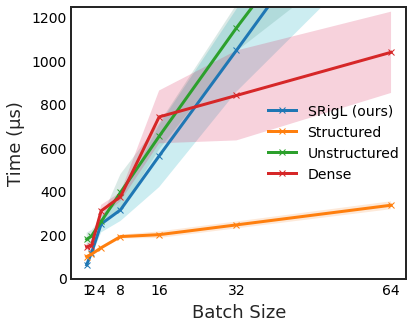

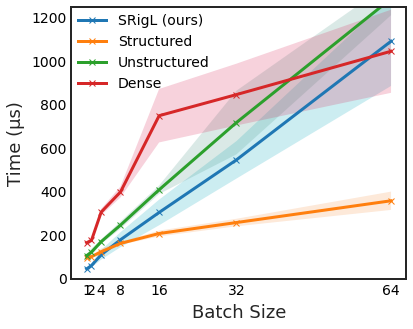

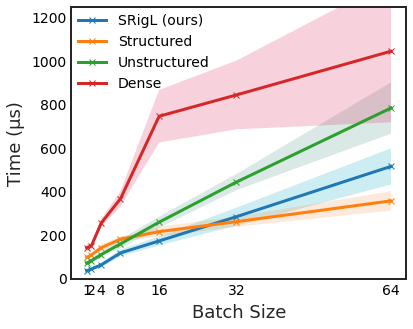

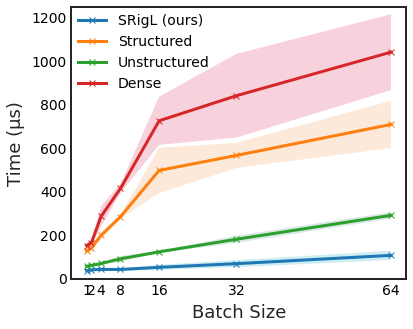

In [4]:
import re
import pandas as pd
import numpy as np
from math import log2
plt.style.use("./plt_plot_style.mplstyle")
target_descriptions = {
    "Fine-grained + structured with backend inductor": "SRigL (ours)",
    "Structured sparsity compiled with backend - inductor": "Structured",
    "csr only compiled with backend - inductor": "Unstructured",
    "Dense benchmark - Compiled - backend inductor": "Dense",
    # "Vmap - eager"
}
data = {
    "sparsity": [],
    "batch_size": [],
    "num_features": [],
    "time": [],
    "std": [],
    "description": []
}


_COLOURS = sns.color_palette("tab10").as_hex()
import pickle
for threads in [4,]:
# threads = 2
    device = "cpu"
    compiler = "inductor"
    dtype="torch.float32"
    file_name = f"benchmark_v2_{device}_threads_{threads}_compiler_{compiler}_dtype_{dtype}final_{_FNAME_SUFFIX}.pkl"
    with open(f"../{file_name}", "rb") as handle:
        compare = pickle.load(handle)
    # print(compare)

    _y_lim = None
    # fig, axs = plt.subplots(2, 2)
    # ax_idx = 0
    # row_idx = 0
    for _sparsity in [80, 90, 95, 99]:
        data = {
            "sparsity": [],
            "batch_size": [],
            "num_features": [],
            "time": [],
            "std": [],
            "description": []
        }
        # _sparsity = 99
        for measurement in compare._results:
            sparsity_match = re.match(f"Sparsity ([0-9]*)", measurement.title)
            sparsity = sparsity_match.groups()[0]

            thread_match = re.match(f".*with ([0-9]*) threads.*", measurement.title)
            threads = thread_match.groups()[0]
            desc = measurement.description
            if int(sparsity) not in [_sparsity,]:
                continue
            if desc not in target_descriptions.keys():
                continue
            # if desc == "Dense benchmark - Compiled - backend inductor" and int(sparsity) != 95:
            #     continue
            data["description"].append(target_descriptions[desc])
            data["sparsity"].append(int(sparsity))
            batch, num_features = re.findall(r"[0-9]+", measurement.sub_label)
            data["batch_size"].append(int(batch))
            data["num_features"].append(int(num_features))
            data["time"].append(measurement.median*1e6)
            data["std"].append(np.std(measurement.times)*1e6)
        df = pd.DataFrame(data)
        _DESC_ORDER = list(target_descriptions.values())
        # df["description"] = pd.Categorical(df["description"], categories=_DESC_ORDER)
        df = df.sort_values(by="batch_size", ascending=True)
        fig, ax = plt.subplots(figsize=_FIG_SIZE)
        _max_batch=64
        df = df.loc[df["batch_size"]<=_max_batch]  # TODO: Also sort by desc?
        lines = ["solid", "dashed", "dashdot", "dotted"]
        for i, d in enumerate(_DESC_ORDER):
            colour = _COLOURS[i]
            for ii, s in enumerate(df["sparsity"].unique()):
                line = lines[ii]
                df_slice = df.loc[(df["sparsity"] == s) & (df["description"]==d)]
                # df_slice = df_slice.groupby("batch_size").agg(mean_time=("time", "mean"), std_time=("time", "std")).reset_index()
                if len(df_slice) > 0:
                    ax.plot(df_slice["batch_size"], df_slice["time"], label=f"{d}", marker="x", ls=line, color=colour)
                    ax.fill_between(
                        df_slice["batch_size"],
                        df_slice["time"]+df_slice["std"],
                        df_slice["time"]-df_slice["std"],
                        alpha=0.2
                    )
        y_max = df.loc[df["description"]=="Dense"]["time"].max() 
        if _y_lim is None:
            _y_lim = y_max + y_max * 0.2
        plt.ylim(top=_y_lim, bottom=0)
        plt.legend()
        plt.ylabel("Time (\u03bcs)")
        plt.xlabel("Batch Size")
        ax.set_xticks([2**i for i in range(int(log2(_max_batch*2)))])
        # plt.grid(True, which="both")

        # plt.title(f"{_sparsity}% sparsity {threads} threads")
        # ax.set_xscale("log")
        # ax.set_yscale("log")
        plt.show()
        fig.savefig(f"../figs/threads-{threads}-sparsity-{_sparsity}-device{device}.png", dpi=400, transparent=False)
        fig.savefig(f"../figs/threads-{threads}-sparsity-{_sparsity}-device{device}.pdf", dpi=600, transparent=False)


In [5]:
df["sparsity"].unique()


array([99])

In [6]:
def remove_outliers(df):
    for i, row in df.iterrows():
        q75, q25 = np.percentile(row["times"], [75 ,25])
        # q75, q25 = np.percentile(row["times"], [49, 50])
        
        iqr = q75 - q25
        org_median = row["time"]
        org_std = row["std"]
        updated_times = [t for t in row["times"] if (t < 1.5*iqr+q75) or (t > q25-1.5*iqr)]
        # updated_times = [t for ii,t in enumerate(row["times"]) if ii >=3]
        # updated_times = [t for ii,t in enumerate(row["times"]) if t<1000]
        print(f"dropped {len(row['times'])-len(updated_times)} times")
        updated_std = np.std(updated_times)
        updated_time = np.median(updated_times)
        # df.loc[i,"times"] = updated_times
        print(f"ORIG STD: {org_std}, updated: {updated_std}")
        df.loc[i,"std"] = updated_std
        df.loc[i,"time"] = updated_time
            # print(f"Updated median: {org_median} -> {df.iloc[i]['time']}, {updated_time}")
            # print(f"Updated std: {org_std} -> {df.iloc[i]['std']}")
            # print(f"iqr: {iqr}")
        return df


Plotting 0, 0
max std: 5668.3971099200735
dropped 0 times
ORIG STD: 2549.071705198476, updated: 2549.071705198476
max std: 5668.3971099200735
Plotting 0, 1
max std: 3525.7725478940283
dropped 0 times
ORIG STD: 2559.466253981505, updated: 2559.466253981505
max std: 3525.7725478940283
Plotting 1, 0
max std: 1794.0481698749147
dropped 0 times
ORIG STD: 1152.713384352436, updated: 1152.713384352436
max std: 1794.0481698749147
Plotting 1, 1
max std: 2794.9152743758486
dropped 0 times
ORIG STD: 931.6181009428634, updated: 931.6181009428634
max std: 2794.9152743758486


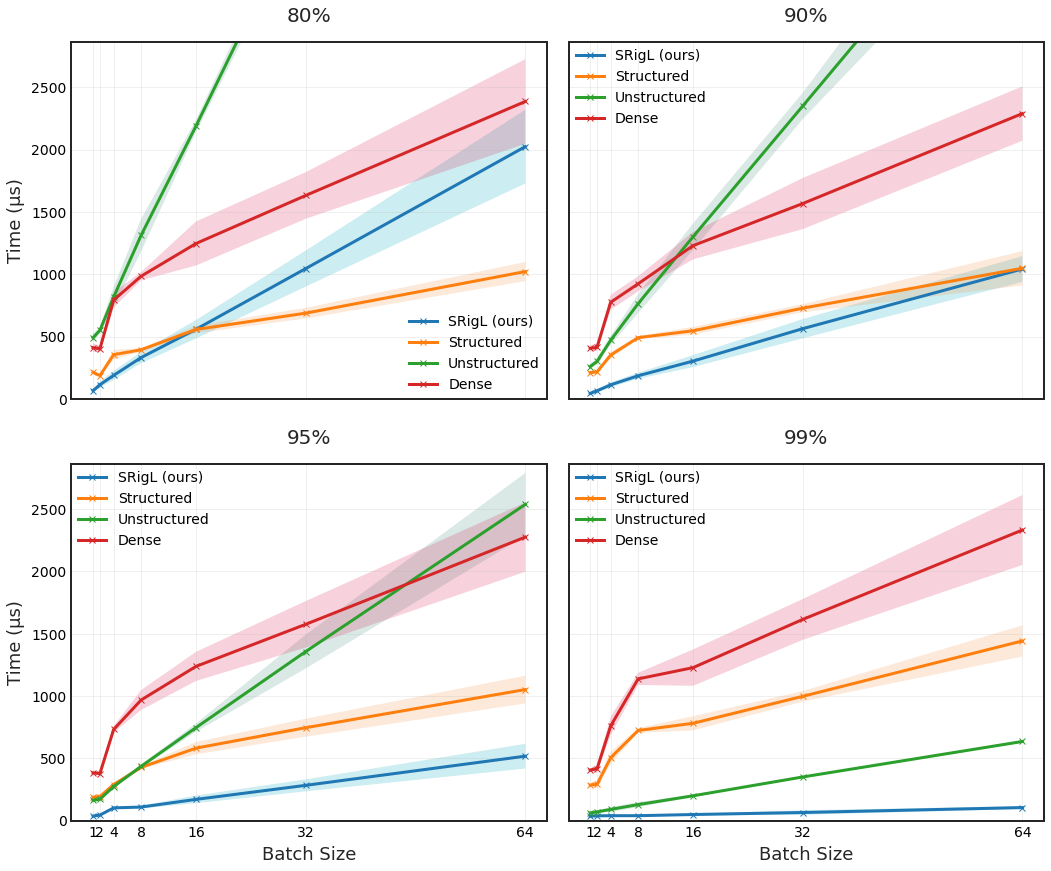

Plotting 0, 0
max std: 5592.312267696211
dropped 0 times
ORIG STD: 1284.4592886906348, updated: 1284.4592886906346
max std: 5592.312267696211
Plotting 0, 1
max std: 2887.325323598128
dropped 0 times
ORIG STD: 1113.6077455980005, updated: 1113.6077455980007
max std: 2887.325323598128
Plotting 1, 0
max std: 2138.676264780797
dropped 0 times
ORIG STD: 490.1384221283798, updated: 490.1384221283798
max std: 2138.676264780797
Plotting 1, 1
max std: 3157.860833499952
dropped 0 times
ORIG STD: 3157.860833499952, updated: 3157.860833499952
max std: 3157.860833499952


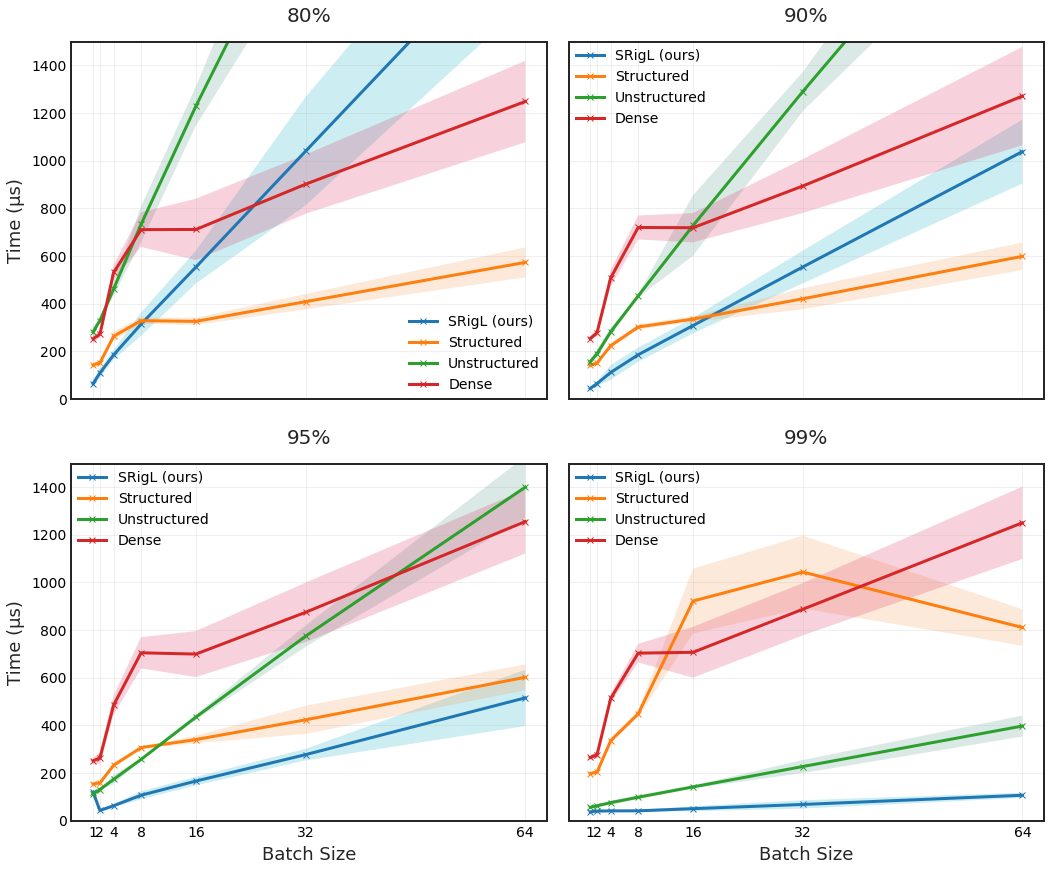

Plotting 0, 0
max std: 7907.243042909453
dropped 0 times
ORIG STD: 529.8519996859993, updated: 529.8519996859992
max std: 7907.243042909453
Plotting 0, 1
max std: 3498.3840041281246
dropped 0 times
ORIG STD: 1679.6917214191285, updated: 1679.6917214191287
max std: 3498.3840041281246
Plotting 1, 0
max std: 2947.2454883247065
dropped 0 times
ORIG STD: 2264.6035986188513, updated: 2264.6035986188513
max std: 2947.2454883247065
Plotting 1, 1
max std: 2050.1076282204376
dropped 0 times
ORIG STD: 2050.1076282204376, updated: 2050.1076282204376
max std: 2050.1076282204376


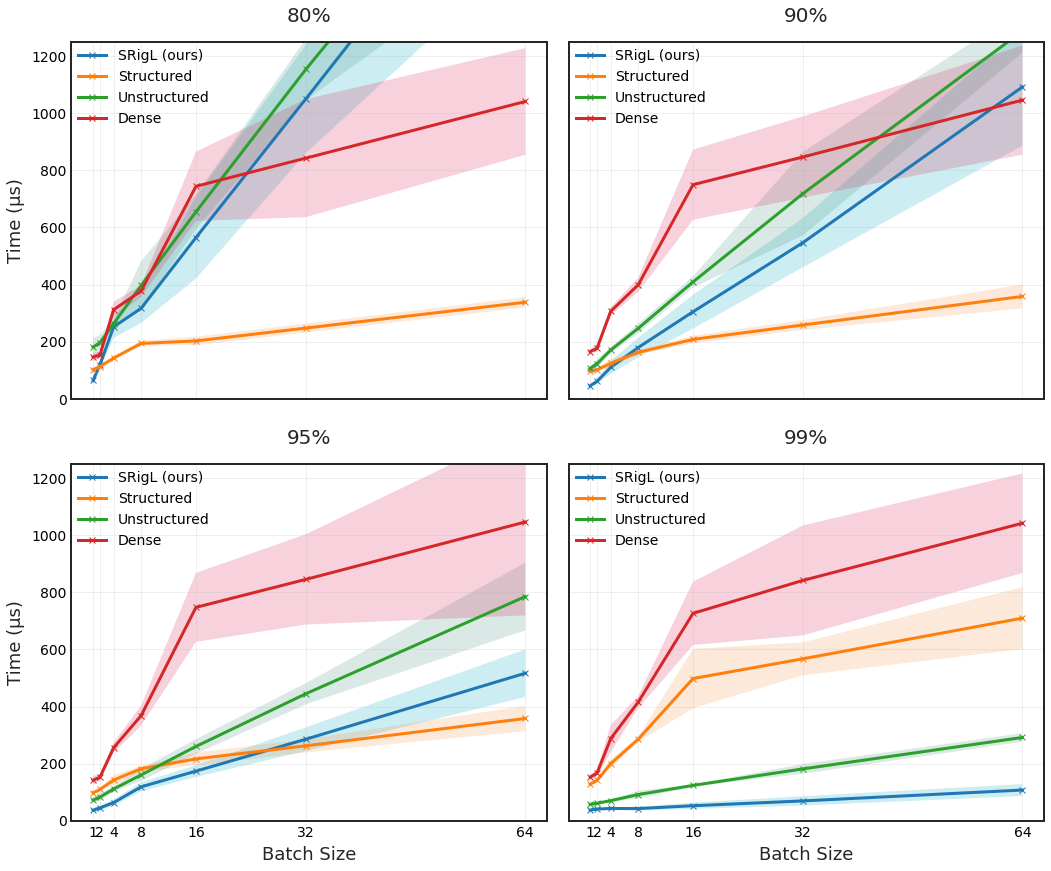

Plotting 0, 0
max std: 3310.418050377102
dropped 0 times
ORIG STD: 855.2890771021182, updated: 855.289077102118
max std: 3310.418050377102
Plotting 0, 1
max std: 1805.827025158614
dropped 0 times
ORIG STD: 813.5398532130927, updated: 813.5398532130927
max std: 1805.827025158614
Plotting 1, 0
max std: 1005.2911003098609
dropped 0 times
ORIG STD: 886.6277326938523, updated: 886.6277326938522
max std: 1005.2911003098609
Plotting 1, 1
max std: 997.3270982827241
dropped 0 times
ORIG STD: 997.3270982827241, updated: 997.3270982827239
max std: 997.3270982827239


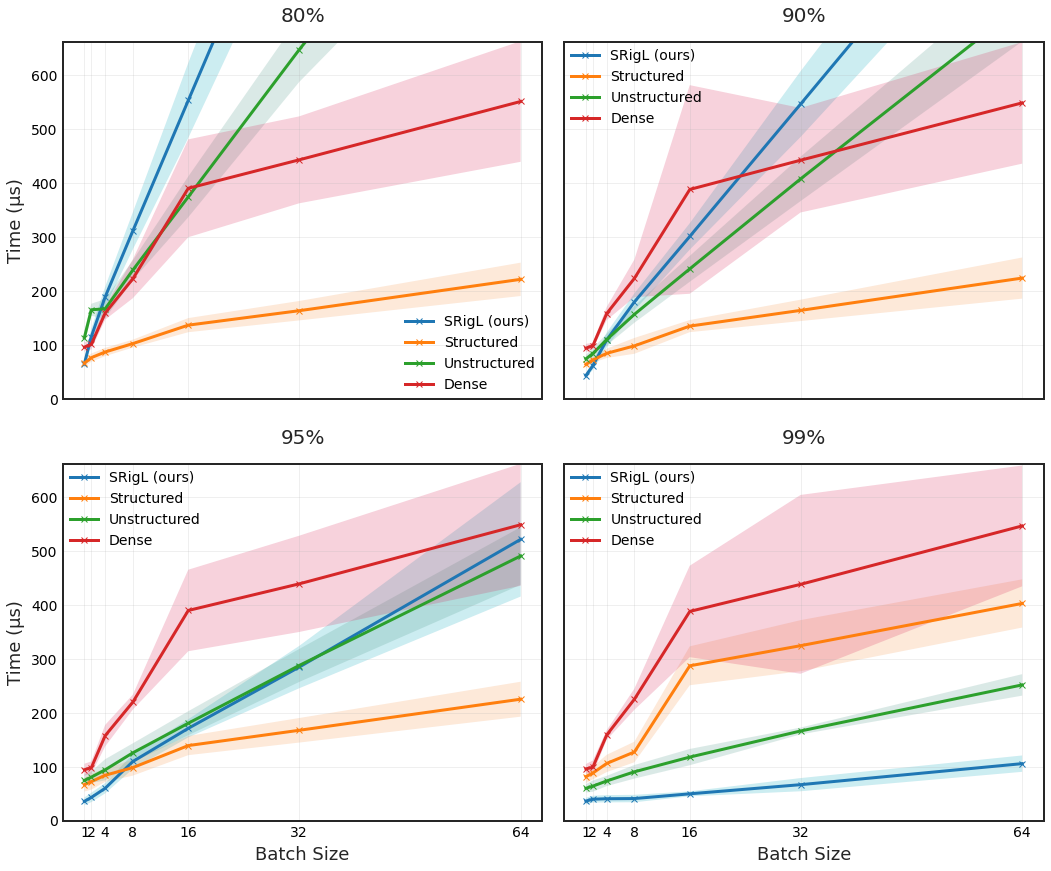

Plotting 0, 0
max std: 9641.081482917529
dropped 0 times
ORIG STD: 5685.231912422151, updated: 5685.23191242215
max std: 9641.081482917529
Plotting 0, 1
max std: 14291.748557183413
dropped 0 times
ORIG STD: 6588.705055731587, updated: 6588.705055731587
max std: 14291.748557183413
Plotting 1, 0
max std: 8467.717774903778
dropped 0 times
ORIG STD: 5631.146360772272, updated: 5631.146360772271
max std: 8467.717774903778
Plotting 1, 1
max std: 6498.682206824235
dropped 0 times
ORIG STD: 6498.682206824235, updated: 6498.682206824236
max std: 6498.682206824236


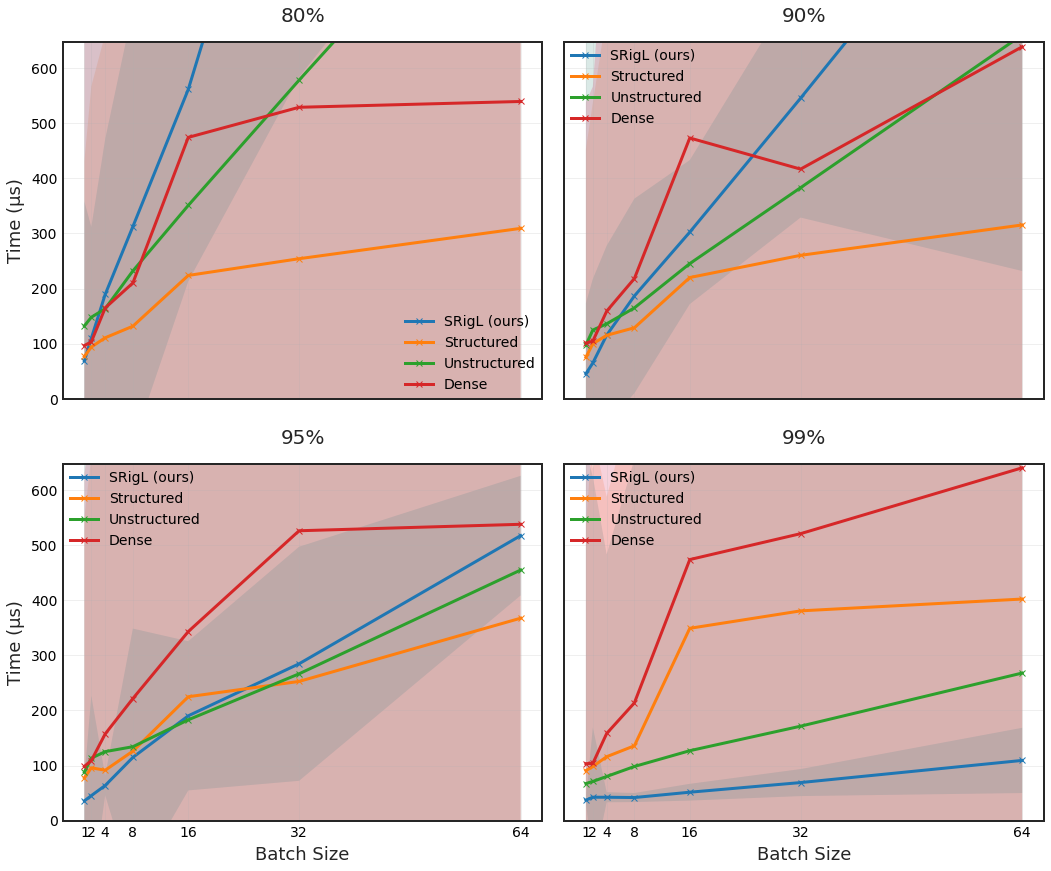

In [28]:
import re
import pandas as pd
import numpy as np
from math import log2
plt.style.use("./plt_plot_style.mplstyle")
target_descriptions = {
    "Fine-grained + structured with backend inductor": "SRigL (ours)",
    "Structured sparsity compiled with backend - inductor": "Structured",
    # "structured + csr with backend inductor": "Structured+csr",
    "csr only compiled with backend - inductor": "Unstructured",
    "Dense benchmark - Compiled - backend inductor": "Dense",
    # "Vmap - eager"
}
data = {
    "sparsity": [],
    "batch_size": [],
    "num_features": [],
    "time": [],
    "std": [],
    "description": []
}


_COLOURS = sns.color_palette("tab10").as_hex()
import pickle
for threads in [1,2,4,8,16]:
# threads = 2
    device = "cpu"
    compiler = "inductor"
    dtype="torch.float32"
    file_name = f"benchmark_v2_{device}_threads_{threads}_compiler_{compiler}_dtype_{dtype}final_{_FNAME_SUFFIX}.pkl"
    with open(f"../{file_name}", "rb") as handle:
        compare = pickle.load(handle)
    # print(compare)

    _y_lim = None
    fig, axs = plt.subplots(2, 2, figsize=[f * 2.5 for f in _FIG_SIZE],sharex=True, sharey=True)
    col_idx = 0
    row_idx = 0
    for _s_idx,_sparsity in enumerate([80, 90, 95, 99]):
        col_idx = 0
        if _s_idx > 1:
            row_idx = 1
        if _s_idx % 2 != 0:
            col_idx = 1
        print(f"Plotting {row_idx}, {col_idx}")
        data = {
            "sparsity": [],
            "batch_size": [],
            "num_features": [],
            "time": [],
            "std": [],
            "description": [],
            "times": []
        }
        # _sparsity = 99
        for measurement in compare._results:
            sparsity_match = re.match(f"Sparsity ([0-9]*)", measurement.title)
            sparsity = sparsity_match.groups()[0]

            thread_match = re.match(f".*with ([0-9]*) threads.*", measurement.title)
            threads = thread_match.groups()[0]
            desc = measurement.description
            if int(sparsity) not in [_sparsity,]:
                continue
            if desc not in target_descriptions.keys():
                continue
            # if desc == "Dense benchmark - Compiled - backend inductor" and int(sparsity) != 95:
            #     continue
            data["description"].append(target_descriptions[desc])
            data["sparsity"].append(int(sparsity))
            batch, num_features = re.findall(r"[0-9]+", measurement.sub_label)
            data["batch_size"].append(int(batch))
            data["num_features"].append(int(num_features))
            data["time"].append(measurement.median*1e6)
            data["std"].append(np.std(measurement.times)*1e6)
            data["times"].append([t*1e6 for t in measurement.times])
        df = pd.DataFrame(data)
        print(f"max std: {df['std'].max()}")
        df = remove_outliers(df)
        print(f"max std: {df['std'].max()}")
        _DESC_ORDER = list(target_descriptions.values())
        # df["description"] = pd.Categorical(df["description"], categories=_DESC_ORDER)
        df = df.sort_values(by="batch_size", ascending=True)
        # fig, ax = plt.subplots(figsize=_FIG_SIZE)
        _max_batch=64
        df = df.loc[df["batch_size"]<=_max_batch]  # TODO: Also sort by desc?
        lines = ["solid", "dashed", "dashdot", "dotted"]
        for i, d in enumerate(_DESC_ORDER):
            colour = _COLOURS[i]
            for ii, s in enumerate(df["sparsity"].unique()):
                line = lines[ii]
                df_slice = df.loc[(df["sparsity"] == s) & (df["description"]==d)]
                # df_slice = df_slice.groupby("batch_size").agg(mean_time=("time", "mean"), std_time=("time", "std")).reset_index()
                if len(df_slice) > 0:
                    axs[row_idx, col_idx].plot(df_slice["batch_size"], df_slice["time"], label=f"{d}", marker="x", ls=line, color=colour)
                    axs[row_idx, col_idx].fill_between(
                        df_slice["batch_size"],
                        df_slice["time"]+df_slice["std"],
                        df_slice["time"]-df_slice["std"],
                        alpha=0.2
                    )
        y_max = df.loc[df["description"]=="Dense"]["time"].max() 
        if _y_lim is None:
            _y_lim = y_max + y_max * 0.2
        axs[row_idx, col_idx].set_ylim(top=_y_lim, bottom=0)
        axs[row_idx, col_idx].legend()
        plt.ylabel("Time (\u03bcs)")
        plt.xlabel("Batch Size")
        axs[row_idx, col_idx].set_xticks([2**i for i in range(int(log2(_max_batch*2)))])
        # axs[row_idx, col_idx].set_title(f"Sparsity {_sparsity}%", fontsize=20)
        axs[row_idx, col_idx].set_title(f"{_sparsity}%", fontsize=20)
        axs[row_idx, col_idx].grid(True, alpha=0.25)
        
    for ax in axs.flat:
        ax.set(xlabel="Batch Size", ylabel="Time (\u03bcs)")

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()
        

        
        # plt.grid(True, which="both")

        # plt.title(f"{_sparsity}% sparsity {threads} threads")
        # ax.set_xscale("log")
        # ax.set_yscale("log")
    plt.grid(True, alpha=0.25)
    fig.tight_layout()
    plt.show()
    fig.savefig(f"../figs/multi_plot_threads-{threads}.png", dpi=400, transparent=False)
    fig.savefig(f"../figs/multi_plot_threads-{threads}.pdf", dpi=600, transparent=False)


In [8]:
# import re
# import pandas as pd
# import numpy as np
# plt.style.use("../plt_plot_style.mplstyle")


# import pickle
# for threads in [1,2,4,8,]:
#     device = "cpu"``
#     compiler = "inductor"
#     dtype="torch.float32"
#     file_name = f"benchmark_v2_{device}_threads_{threads}_compiler_{compiler}_dtype_{dtype}final_hector_second_run.pkl"
#     with open(f"../{file_name}", "rb") as handle:
#         compare = pickle.load(handle)
#     # print(compare)

#     _y_lim = None
#     for _sparsity in [80, 90, 95, 99]:
#         data = {
#             "sparsity": [],
#             "batch_size": [],
#             "num_features": [],
#             "time": [],
#             "std": [],
#             "description": [],
#             "times":[]
#         }
#         # _sparsity = 99
#         for measurement in compare._results:
#             sparsity_match = re.match(f"Sparsity ([0-9]*)", measurement.title)
#             sparsity = sparsity_match.groups()[0]

#             thread_match = re.match(f".*with ([0-9]*) threads.*", measurement.title)
#             threads = thread_match.groups()[0]
#             desc = measurement.description
#             if int(sparsity) not in [_sparsity,]:
#                 continue
#             if desc not in target_descriptions.keys():
#                 continue
#             # if desc == "Dense benchmark - Compiled - backend inductor" and int(sparsity) != 95:
#             #     continue
#             data["description"].append(target_descriptions[desc])
#             data["sparsity"].append(int(sparsity))
#             batch, num_features = re.findall(r"[0-9]+", measurement.sub_label)
#             data["batch_size"].append(int(batch))
#             data["num_features"].append(int(num_features))
#             data["time"].append(measurement.median*1e6)
#             data["times"].append([t*1e6 for t in measurement.times])
#             data["std"].append(np.std(measurement.times)*1e6)

#         df = pd.DataFrame(data)
#         df = df.sort_values(by="batch_size", ascending=True)
#         fig, ax = plt.subplots(figsize=_FIG_SIZE)
#         df = df.loc[df["batch_size"]<=64]  # TODO: Also sort by desc?
#         lines = ["solid", "dashed", "dashdot", "dotted"]
#         colours = ["red", "green", "blue", "orange"]
#         df_slice = df.loc[(df["sparsity"] == _sparsity) & (df["batch_size"]==1)]
#         ax.boxplot(df_slice["times"], labels=df_slice["description"])

#         # # for i, d in enumerate(df["description"].unique()):
#         #     colour = colours[i]
#         #     df_slice = df.loc[(df["sparsity"] == _sparsity) & (df["description"]==d) & (df["batch_size"]==1)]
#         #     # ax.boxplot(df_slice["times"], label=f"{d}", marker="x", color=colour)
#         #     ax.boxplot(df_slice["times"])
#         y_max = df.loc[(df["batch_size"]==1)]["time"].max() 
#         if _y_lim is None:
#             _y_lim = y_max + y_max * 0.2
#         plt.ylim(top=_y_lim, bottom=0)
#         plt.legend()
#         plt.ylabel("Time (\u03bc s)")
#         plt.xlabel("Batch Size")
#         # plt.grid(True, which="both")

#         plt.title(f"{_sparsity}% sparsity {threads} threads")
#         # ax.set_xscale("log")
#         # ax.set_yscale("log")
#         plt.show()
#         fig.savefig(f"../figs/single-sample-threads-{threads}-sparsity-{_sparsity}.png", dpi=400, transparent=False)


In [9]:
target_descriptions.values()


dict_values(['SRigL (ours)', 'Structured', 'Unstructured', 'Dense'])

101


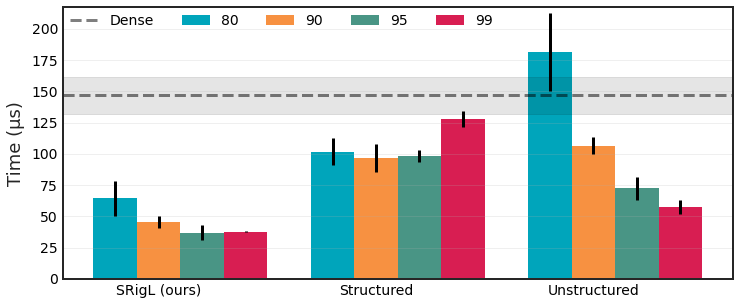

In [26]:
import re
import pandas as pd
import numpy as np
plt.style.use("./plt_plot_style.mplstyle")


import pickle
# for threads in [1,2,4,8,16]:
for threads in [4,]:
    device = "cpu"
    compiler = "inductor"
    dtype="torch.float32"
    file_name = f"benchmark_v2_{device}_threads_{threads}_compiler_{compiler}_dtype_{dtype}final_{_FNAME_SUFFIX}.pkl"    
    with open(f"../{file_name}", "rb") as handle:
        compare = pickle.load(handle)


    data = {
        "sparsity": [],
        "batch_size": [],
        "num_features": [],
        "time": [],
        "std": [],
        "description": [],
        "times":[]
    }
    for measurement in compare._results:
        sparsity_match = re.match(f"Sparsity ([0-9]*)", measurement.title)
        sparsity = sparsity_match.groups()[0]

        thread_match = re.match(f".*with ([0-9]*) threads.*", measurement.title)
        threads = thread_match.groups()[0]
        desc = measurement.description
        if desc not in target_descriptions.keys():
            continue
        data["description"].append(target_descriptions[desc])
        data["sparsity"].append(int(sparsity))
        batch, num_features = re.findall(r"[0-9]+", measurement.sub_label)
        data["batch_size"].append(int(batch))
        data["num_features"].append(int(num_features))
        data["time"].append(measurement.median*1e6)
        data["times"].append([t*1e6 for t in measurement.times])
        data["std"].append(np.std(measurement.times)*1e6)


    df = pd.DataFrame(data)
    df = df.reset_index()
    df = df.loc[df["batch_size"]==1].reset_index()
    # if threads == "16":

    min_runs = np.inf
    for t in df['times']:
        if len(t)<min_runs:
            min_runs=len(t)
    print(min_runs)
    _DESC_ORDER = list(target_descriptions.values())
    df["description"] = pd.Categorical(df["description"], categories=_DESC_ORDER)
    df = df.sort_values(by="batch_size", ascending=True)
    x = np.arange(3)  # the label locations
    width = 0.2  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(figsize=(_FIG_SIZE[0]*2, _FIG_SIZE[1]))  
    df_one_sample = df.loc[(df["batch_size"]==1) & (df["description"]!="Dense")]
    df_one_sample = df_one_sample.sort_values(by=["description"], ascending=True)
    for sparsity in [ 80, 90, 95, 99]:
        df_slice = df_one_sample.loc[df_one_sample['sparsity']==sparsity]
        offset = width * multiplier
        rects = ax.bar(x + offset, df_slice["time"], width, label=sparsity, align="center", yerr=df_slice["std"])
        multiplier += 1
    dense_time = df.loc[(df["description"]=="Dense") & (df["sparsity"]==80) & (df["batch_size"]==1)]["time"].item()
    std = df.loc[(df["description"]=="Dense") & (df["sparsity"]==80) & (df["batch_size"]==1)]["std"].item()
    plt.axhline(y=dense_time, color='black', linestyle='--', label='Dense', alpha=0.5)
    # plt.fill_between([-100, 100], dense_time+std, dense_time-std, alpha=0.1, color="black")
    
    ax.fill_between(ax.get_xlim(), dense_time+std, dense_time-std, alpha=0.1, color="black")
    # _alpha=0.2
    # plt.axhline(y=dense_time+std, color='black', linestyle='--', alpha=_alpha)
    # plt.axhline(y=dense_time-std, color='black', linestyle='--', alpha=_alpha)
    ax.set_ylabel('Time (\u03bcs)')
    ax.set_xticks(x + width, _DESC_ORDER[:-1])
    # ax.legend(title="Sparsity", loc='upper left', ncol=5)
    # ax.legend(loc='upper left', ncol=5, frameon=True)
    leg = ax.legend(loc='upper left', ncol=5, facecolor='White', frameon=True)
    leg.get_frame().set_linewidth(0.0)
    y_max = df.loc[(df["batch_size"]==1)]["time"].max() 
    y_lim = y_max + y_max*0.2
    # y_lim = dense_time + dense_time * 0.2
    plt.ylim(top=y_lim, bottom=0)
    # plt.ylim(top=200, bottom=0)
    # ax.set_xlim=([0,2])
    ax.margins(0)  
    # plt.tight_layout(pad=0,h_pad=0)
    # plt.grid(axis="y", alpha=0.4)
    plt.grid(axis="y", alpha=0.25)

    fig.show()

    # plt.title(f"{threads} threads")
    fig.savefig(f"../figs/grouped-bar-threads-{threads}.png", dpi=600, bbox_inches="tight")
    fig.savefig(f"../figs/grouped-bar-threads-{threads}.pdf", dpi=600, bbox_inches="tight")


In [21]:
df.loc[(df["sparsity"]==90) & df["batch_size"]==1]


,level_0,index,sparsity,batch_size,num_features,time,std,description,times
8,140,140,90,1,3072,165.577605,8.118187,Dense,"[274.6341750025749, 237.1754962950945, 235.084..."
9,141,141,90,1,3072,96.917227,11.143622,Structured,"[97.35111612826586, 97.99443650990725, 96.6895..."
10,142,142,90,1,3072,106.603419,6.649305,Unstructured,"[140.7825853675604, 135.88909059762955, 145.28..."
11,143,143,90,1,3072,45.596142,4.997878,SRigL (ours),"[67.45967082679272, 58.310660533607006, 56.834..."


In [22]:
96.917227/45.596142


2.125557618449385

In [14]:
165.577605/45.596142


3.6313950640823953

In [20]:
146.693690/64.341491	


2.2799236965148975

In [ ]:
for i, row in df.loc[(df["sparsity"]==95) & (df["batch_size"]==1)].iterrows():
    more_than_200 = [t for t in row["times"] if t > 200]
    print(len(more_than_200))


75
51
53
1


In [ ]:
df


,level_0,index,sparsity,batch_size,num_features,time,std,description,times
0,44,44,99,1,3072,103.582162,694.423050,Dense,"[21467.09570661187, 15273.272059857845, 22669...."
1,45,45,99,1,3072,90.899877,445.743067,Structured,"[15976.090915501118, 10792.122222483158, 21151..."
2,46,46,99,1,3072,67.516696,603.024666,Unstructured,"[18881.422001868486, 28339.704032987356, 6811...."
3,47,47,99,1,3072,37.504490,1.781048,SRigL (ours),"[50.461539067327976, 49.47471898049116, 48.150..."
4,92,92,95,1,3072,98.651275,529.997201,Dense,"[21468.876861035824, 14643.491711467505, 17459..."
5,93,93,95,1,3072,77.992911,471.249884,Structured,"[18832.738045603037, 11789.078824222088, 21213..."
6,94,94,95,1,3072,88.451197,833.809254,Unstructured,"[42435.15897542238, 21087.042056024075, 173.38..."
7,95,95,95,1,3072,36.146957,41.972225,SRigL (ours),"[6659.531034529209, 68.35907697677612, 51.1603..."
8,140,140,90,1,3072,101.051293,436.830409,Dense,"[21370.007190853357, 10729.447938501835, 21238..."
9,141,141,90,1,3072,75.298827,377.280724,Structured,"[31870.44709920883, 10738.917626440525, 13181...."


In [ ]:
142.169371/36.942507	


3.8483953187042776

In [ ]:
72.288010 / 36.942507


1.956770557017151

In [ ]:
min_runs = 0
for t in df['times']:
    if len(t)>min_runs:
        min_runs=len(t)
print(min_runs)


25699


In [ ]:
df['times']


0     [21467.09570661187, 15273.272059857845, 22669....
1     [15976.090915501118, 10792.122222483158, 21151...
2     [18881.422001868486, 28339.704032987356, 6811....
3     [50.461539067327976, 49.47471898049116, 48.150...
4     [21468.876861035824, 14643.491711467505, 17459...
5     [18832.738045603037, 11789.078824222088, 21213...
6     [42435.15897542238, 21087.042056024075, 173.38...
7     [6659.531034529209, 68.35907697677612, 51.1603...
8     [21370.007190853357, 10729.447938501835, 21238...
9     [31870.44709920883, 10738.917626440525, 13181....
10    [32333.27530324459, 42109.21190679073, 15882.6...
11    [14690.321870148182, 102.47621685266495, 75.02...
12    [22451.56792923808, 13502.958230674267, 33128....
13    [21327.428985387087, 10702.039115130901, 12602...
14    [46479.460783302784, 17205.405049026012, 169.7...
15    [15378.979966044426, 28641.4697766304, 151.026...
Name: times, dtype: object

In [ ]:
ax.get_xlim()


(-0.24000000000000002, 2.8400000000000003)

In [ ]:
df.loc[(df["description"]=="Dense") & (df["sparsity"]==80) & (df["batch_size"]==1)]["time"]


12    96.704811
Name: time, dtype: float64

In [ ]:
df_slice = adf.loc[(df["batch_size"]==1) & (df["sparsity"]==80)].sort_values(by="time")
df_slice


NameError: name 'adf' is not defined

In [ ]:
df_slice


,sparsity,batch_size,num_features,time,std,description,times
191,80,1,3072,65.143271,7.295133,Struct. + Const. fan-in,"[83.1374991685152, 71.49433251470327, 82.84409..."
189,80,1,3072,66.409758,7.608274,Struct. only,"[68.66620853543282, 81.38469886034727, 98.4539..."
188,80,1,3072,96.018100,8.551347,Dense,"[116.68731458485126, 116.33289977908134, 116.6..."
190,80,1,3072,113.703799,12.253186,CSR,"[168.0694054812193, 169.08892430365086, 185.36..."


In [ ]:
df_slice["description"] = pd.Categorical(df_slice["description"], categories=_DESC_ORDER)


In [ ]:
df_slice


,sparsity,batch_size,num_features,time,std,description,times
191,80,1,3072,65.143271,7.295133,Struct. + Const. fan-in,"[83.1374991685152, 71.49433251470327, 82.84409..."
189,80,1,3072,66.409758,7.608274,Struct. only,"[68.66620853543282, 81.38469886034727, 98.4539..."
188,80,1,3072,96.018100,8.551347,Dense,"[116.68731458485126, 116.33289977908134, 116.6..."
190,80,1,3072,113.703799,12.253186,CSR,"[168.0694054812193, 169.08892430365086, 185.36..."


In [ ]:
def error_bar(df)


SyntaxError: expected ':' (3123403499.py, line 1)

In [ ]:
df


,sparsity,batch_size,num_features,time,std,description,times
95,95,1,3072,36.167209,7.155722,SRigL: Struct. + Const. fan-in,"[49.483818002045155, 43.286317959427834, 42.01..."
189,80,1,3072,66.409758,7.608274,SRigL: Struct. only,"[68.66620853543282, 81.38469886034727, 98.4539..."
188,80,1,3072,96.018100,8.551347,Dense,"[116.68731458485126, 116.33289977908134, 116.6..."
143,90,1,3072,43.218883,3.936562,SRigL: Struct. + Const. fan-in,"[66.5759714320302, 53.861113265156746, 50.8129..."
142,90,1,3072,74.157577,7.384433,RigL: CSR,"[74.1732306778431, 74.03820753097534, 74.09465..."
...,...,...,...,...,...,...,...
145,80,2048,3072,4091.660026,507.042419,SRigL: Struct. only,"[5456.481594592333, 4281.3727632164955, 5051.9..."
146,80,2048,3072,32193.977386,2771.154095,RigL: CSR,"[32116.779126226902, 32232.029363512993, 32061..."
147,80,2048,3072,61874.275794,2506.466313,SRigL: Struct. + Const. fan-in,"[61490.65587669611, 61845.004092901945, 64001...."
96,90,2048,3072,8210.071828,813.539853,Dense,"[8181.014098227024, 8127.561770379543, 8154.54..."


In [ ]:
target_descriptions


{'Fine-grained + structured with backend inductor': 'SRigL: Struct. + Const. fan-in',
 'Dense benchmark - Compiled - backend inductor': 'Dense',
 'Structured sparsity compiled with backend - inductor': 'SRigL: Struct. only',
 'csr only compiled with backend - inductor': 'RigL: CSR'}

In [ ]:
df_one_sample


,sparsity,batch_size,num_features,time,std,description,times
188,80,1,3072,96.018100,8.551347,Dense,"[116.68731458485126, 116.33289977908134, 116.6..."
190,80,1,3072,113.703799,12.253186,RigL: CSR,"[168.0694054812193, 169.08892430365086, 185.36..."
191,80,1,3072,65.143271,7.295133,SRigL: Struct. + Const. fan-in,"[83.1374991685152, 71.49433251470327, 82.84409..."
189,80,1,3072,66.409758,7.608274,SRigL: Struct. only,"[68.66620853543282, 81.38469886034727, 98.4539..."
140,90,1,3072,94.075943,7.877512,Dense,"[115.3046265244484, 113.46759274601936, 111.04..."
142,90,1,3072,74.157577,7.384433,RigL: CSR,"[74.1732306778431, 74.03820753097534, 74.09465..."
143,90,1,3072,43.218883,3.936562,SRigL: Struct. + Const. fan-in,"[66.5759714320302, 53.861113265156746, 50.8129..."
141,90,1,3072,63.819410,7.686303,SRigL: Struct. only,"[64.63028024882078, 63.236732967197895, 79.616..."
92,95,1,3072,94.695645,11.145538,Dense,"[111.89770884811878, 111.07702739536762, 110.7..."
94,95,1,3072,74.867341,11.555546,RigL: CSR,"[76.88581012189388, 75.55900141596794, 78.2033..."


In [ ]:
target_descriptions


{'Fine-grained + structured with backend inductor': 'SRigL: Struct. + Const. fan-in',
 'Dense benchmark - Compiled - backend inductor': 'Dense',
 'Structured sparsity compiled with backend - inductor': 'SRigL: Struct. only',
 'csr only compiled with backend - inductor': 'RigL: CSR'}

/tmp/ipykernel_2548849/3585983248.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_slice["description"] = pd.Categorical(df_slice["description"], categories=_DESC_ORDER)
/tmp/ipykernel_2548849/3585983248.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_slice["description"] = pd.Categorical(df_slice["description"], categories=_DESC_ORDER)
/tmp/ipykernel_2548849/3585983248.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

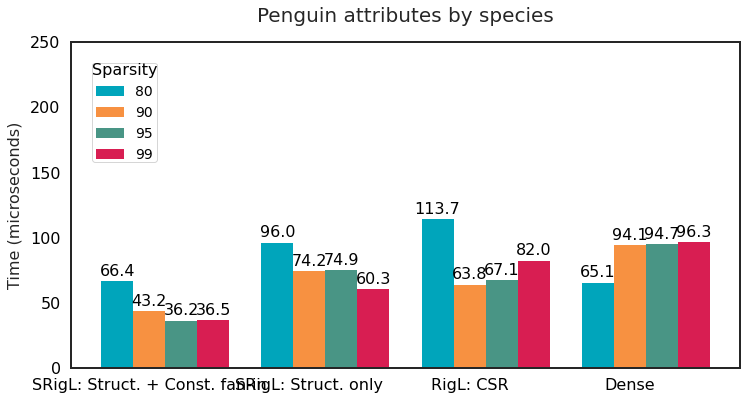

In [ ]:
_DESC_ORDER = list(target_descriptions.values())
x = np.arange(len(target_descriptions))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

# fig, ax = plt.subplots(layout='constrained')
fig, ax = plt.subplots(figsize=(12,6))

df_one_sample = df.loc[df["batch_size"]==1]
df_one_sample = df_one_sample.sort_values(by=["sparsity"])
for sparsity in df_one_sample["sparsity"].unique():
    df_slice = df_one_sample.loc[df_one_sample['sparsity']==sparsity]
    df_slice["description"] = pd.Categorical(df_slice["description"], categories=_DESC_ORDER)
    offset = width * multiplier
    rects = ax.bar(x + offset, df_slice["time"], width, label=sparsity, align="center")
    ax.bar_label(rects, padding=3,labels=[f'{x:,.1f}' for x in rects.datavalues])
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (\u03bcs)')
ax.set_title('Penguin attributes by species')
ax.set_xticks(x + width, target_descriptions.values())
ax.legend(title="Sparsity", loc='upper left')
ax.set_ylim(0, 250)
# plt.tick_params(rotation=45)

plt.show()


In [ ]:
df


,sparsity,batch_size,num_features,time,std,description,times
95,95,1,3072,36.167209,7.155722,SRigL: Struct. + Const. fan-in,"[49.483818002045155, 43.286317959427834, 42.01..."
189,80,1,3072,66.409758,7.608274,SRigL: Struct. only,"[68.66620853543282, 81.38469886034727, 98.4539..."
188,80,1,3072,96.018100,8.551347,Dense,"[116.68731458485126, 116.33289977908134, 116.6..."
143,90,1,3072,43.218883,3.936562,SRigL: Struct. + Const. fan-in,"[66.5759714320302, 53.861113265156746, 50.8129..."
142,90,1,3072,74.157577,7.384433,RigL: CSR,"[74.1732306778431, 74.03820753097534, 74.09465..."
...,...,...,...,...,...,...,...
145,80,2048,3072,4091.660026,507.042419,SRigL: Struct. only,"[5456.481594592333, 4281.3727632164955, 5051.9..."
146,80,2048,3072,32193.977386,2771.154095,RigL: CSR,"[32116.779126226902, 32232.029363512993, 32061..."
147,80,2048,3072,61874.275794,2506.466313,SRigL: Struct. + Const. fan-in,"[61490.65587669611, 61845.004092901945, 64001...."
96,90,2048,3072,8210.071828,813.539853,Dense,"[8181.014098227024, 8127.561770379543, 8154.54..."


In [ ]:
## GPU Timings
import pickle
threads = 1
device = "gpu"
compiler = "inductor"
dtype="torch.float32"
file_name = f"benchmark_v2_{device}_threads_{threads}_compiler_{compiler}_dtype_{dtype}final.pkl"
with open(f"../{file_name}", "rb") as handle:
    compare = pickle.load(handle)
print(compare)


[---------------------------------------------------------------------------------------------------------------------------------- Sparsity 99 with 1 threads using compilation strategy inductor and dtype torch.float32 on device cuda. ---------------------------------------------------------------------------------------------------------------------------------]
                     |  Dense benchmark - eager  |  Structured sparsity - eager  |  structured + csr - eager  |  Vmap - eager  |  Fine-grained + structured - eager  |  Dense benchmark - Compiled - backend inductor  |  Structured sparsity compiled with backend - inductor  |  structured + csr with backend inductor  |  Fine-grained + structured with backend inductor
1 threads: -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

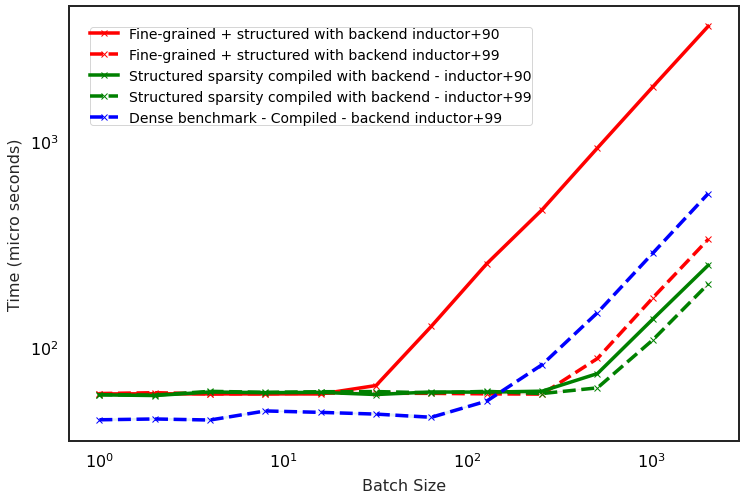

In [ ]:
import re
import pandas as pd
import numpy as np
plt.style.use("../plt_plot_style.mplstyle")
target_descriptions = [
    "Fine-grained + structured with backend inductor",
    # "structured + csr with backend inductor",
    "Dense benchmark - Compiled - backend inductor",
    "Structured sparsity compiled with backend - inductor",
    # "Vmap - eager"
]
data = {
    "sparsity": [],
    "batch_size": [],
    "num_features": [],
    "time": [],
    "std": [],
    "description": []
}
for measurement in compare._results:
    sparsity_match = re.match(f"Sparsity ([0-9]*)", measurement.title)
    sparsity = sparsity_match.groups()[0]

    thread_match = re.match(f".*with ([0-9]*) threads.*", measurement.title)
    threads = thread_match.groups()[0]
    desc = measurement.description
    if int(sparsity) == 80:
        continue
    if desc not in target_descriptions:
        continue
    if desc == "Dense benchmark - Compiled - backend inductor" and int(sparsity) !=99:
        continue
    data["description"].append(desc)
    data["sparsity"].append(int(sparsity))
    batch, num_features = re.findall(r"[0-9]+", measurement.sub_label)
    data["batch_size"].append(int(batch))
    data["num_features"].append(int(num_features))
    data["time"].append(measurement.median*1e6)
    data["std"].append(np.std(measurement.times)*1e6)
df = pd.DataFrame(data)
df = df.sort_values(by="batch_size", ascending=True)
fig, ax = plt.subplots(figsize=(12,8))
df = df.loc[df["batch_size"]<=2048]  # TODO: Also sort by desc?
lines = ["solid", "dashed", "dashdot", "dotted"]
colours = ["red", "green", "blue", "orange"]
for i, d in enumerate(df["description"].unique()):
    colour = colours[i]
    for ii, s in enumerate(df["sparsity"].unique()):
        line = lines[ii]
        df_slice = df.loc[(df["sparsity"] == s) & (df["description"]==d)]
        # df_slice = df_slice.groupby("batch_size").agg(mean_time=("time", "mean"), std_time=("time", "std")).reset_index()
        if len(df_slice) > 0:
            ax.plot(df_slice["batch_size"], df_slice["time"], label=f"{d}+{s}", marker="x", ls=line, color=colour)
            ax.fill_between(
                df_slice["batch_size"],
                df_slice["time"]+df_slice["std"],
                df_slice["time"]-df_slice["std"],
                alpha=0.2
            )
plt.legend()
plt.ylabel("Time (\u03bcs)")
plt.xlabel("Batch Size")
# plt.title(f"{result_type.upper()} Benchmark")
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()
fig.savefig("gpu_benchmark_v2.png", dpi=400, transparent=False)
